#  Convolutional NN it for facial keypoints recognition

Here I will build a convolutional neural network, and train it for the task of facial keypoints recognition. The data are obtained from Kaggle: **LINK**, and consists of **info**.

I will build the CNN using tensorflow **link**. 

##  Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

from sklearn.model_selection import train_test_split
import tensorflow as tf

%matplotlib inline

##  Loading data

In [2]:
training_data_full = pd.read_csv('training.csv')
#training_data.info()

# I will do the splitting here, so that I have a test set that has never been passed 
# through the network.



In [3]:
images = training_data_full['Image'].apply(lambda str_pic: np.array([int(px) for px in str_pic.split()]))

In [4]:
images = np.vstack([images.iloc[i] for i in range(len(images))])

In [5]:
keypoints = training_data_full.drop('Image', axis = 1)

In [6]:
x_train, x_cv, keypoints_train, keypoints_cv = train_test_split(images, keypoints, 
                                                                test_size=100, random_state = 42)

In [7]:
def next_batch(X, labels, batch_size):
    
    sample_indices = np.random.choice(range(len(X)), size = batch_size, 
                                      replace = False)
    
    images = X[sample_indices]
    keypoints = labels.iloc[sample_indices]
        
    return images, keypoints

# Building the CNN

I will start by using the same architechture I used in the course.For the moment I will use train_test_split to test my network a bit. Eventually this wont be necessary, as the dataset provides a separate test set. 

In [71]:
#Some helping functions.
def init_weights(shape):
    init_random_dist = tf.random_normal(shape, stddev=0.1) # Why this stddev?
    return tf.Variable(init_random_dist)

def init_bias(shape):
    init_bias_vals = tf.random_uniform(shape=shape)
    return tf.Variable(init_bias_vals)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2by2(x):
    return tf.nn.max_pool(x, ksize=[1, 4, 4, 1],
                          strides=[1, 4, 4, 1], padding='SAME')

def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W) + b)

def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b


In [72]:
# PLACEHOLDERS

x = tf.placeholder(tf.float32, [None, 9216])
keypoints_true = tf.placeholder(tf.float32, [None, 30])
lr = tf.placeholder(tf.float32)

In [73]:
x_images = tf.image.per_image_standardization(tf.reshape(x, [-1,96,96,1]))

In [74]:
# LAYERS

convo1 = convolutional_layer(x_images, [8,8,1,32]) # 8 x 8 filter, 1 channel in, 32 channels out. SAME padding.
                                            # so output images are also 96 x 96. 
convo1_pool = max_pool_2by2(convo1)   #output of 24 x 24 x 32

In [75]:
convo2 = convolutional_layer(convo1_pool, [4,4,32,64]) # 4x4 filter, 64 outputs. SAME padding.
convo2_pool = max_pool_2by2(convo2) # 6 x 6 x 64

convo2_flat = tf.reshape(convo2_pool,[-1,6*6*64])
full_layer_one = tf.nn.relu(normal_full_layer(convo2_flat,1024))

In [ ]:
"""convo3 = convolutional_layer(convo2_pool, [4,4,64,128]) # 4x4 filter, 64 outputs. SAME padding.
convo3_pool = max_pool_2by2(convo3) # 12 x 12 x 128
convo3_flat = tf.reshape(convo3_pool,[-1,12*12*128])
full_layer_one = tf.nn.relu(normal_full_layer(convo3_flat,1024))"""

In [76]:
# DROPOUT AND OUTPOUT LAYER
drop_prob = tf.placeholder(tf.float32)
full_one_dropout = tf.nn.dropout(full_layer_one, rate = drop_prob)

keypoints_pred = normal_full_layer(full_one_dropout,30)

In [77]:
# LOSS FUNCTION

masked_loss = tf.reduce_mean(tf.square(
        tf.boolean_mask(keypoints_pred-keypoints_true, tf.is_finite(keypoints_true) )
    ))


optimizer = tf.train.AdamOptimizer(learning_rate=lr)
train = optimizer.minimize(masked_loss)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [78]:
# INITIALIZER

init = tf.global_variables_initializer()

In [79]:
saver = tf.train.Saver()

In [36]:
counter = 0

In [80]:
keypoints_mean = keypoints_train.mean()

In [81]:
# Computing error from the mean in order to have a reference. This is the mark I have to beat. 

mean_keypoints_mse = ((keypoints_cv-keypoints_mean)**2).sum(axis = 1).mean()
mean_keypoints_mse

196.28708939228054

Currently on step 5000
Train MSE:  20.343952 

CV MSE: 7.4770584 

train_losses =  [6315.2583, 141.04286, 89.98061, 69.01875, 49.42134, 49.437363, 65.04178, 37.456104, 49.653885, 33.97007, 30.028503, 35.73721, 36.91983, 37.735798, 39.454403, 45.29997, 30.806974, 28.064072, 37.85663, 34.14124, 43.513657, 27.823828, 26.981905, 26.687235, 26.757122, 24.225685, 26.749643, 31.889519, 13.835448, 27.960135, 25.885609, 27.545145, 24.007143, 21.328438, 18.00749, 38.082867, 31.27789, 23.061884, 29.558567, 12.404711, 16.361637, 15.687153, 20.720617, 20.419998, 25.030943, 22.773705, 17.146465, 22.991253, 24.117569, 14.824952, 20.343952] 

cv_losses =  [1880.9608, 33.22513, 25.50578, 30.68725, 14.637615, 13.597893, 24.87399, 12.681085, 11.773998, 11.561777, 11.853491, 10.798853, 11.582228, 13.51698, 10.283081, 9.973906, 9.830541, 12.377462, 19.529902, 10.114228, 9.797491, 10.771721, 9.126305, 10.286642, 8.768046, 8.612425, 8.46893, 8.328036, 8.859966, 7.960964, 7.877246, 9.61753, 8.980762, 7.713110

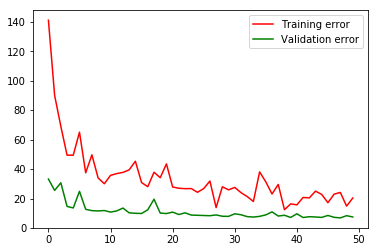

In [84]:
num_steps = 5000

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

with tf.Session() as sess:
    
    sess.run(init)
    #saver.restore(sess, "./saved_models/keypoints_cnn_0")
    train_losses = []
    cv_losses = []
    for iteration in range(num_steps+1):
        
        x_batch, keypoints_batch = next_batch(x_train, keypoints_train, 30)
        
        _ , train_loss = sess.run([train, masked_loss], 
                                  feed_dict={x: x_batch, keypoints_true: keypoints_batch,
                                             drop_prob: 0.5, lr:0.0005})
        
        # PRINT OUT A MESSAGE EVERY 100 STEPS
        
        #if (iteration%20 == 0) and (iteration >0):
            #print(':')
        
        if iteration%100 == 0:
            
            cv_loss = sess.run(masked_loss,feed_dict={x:x_cv,keypoints_true:keypoints_cv,
                                                      drop_prob:0})
            
            train_losses.append(train_loss)
            cv_losses.append(cv_loss)
            
            # Showing output for tracking progress.
            print('=======================================')
            print('Currently on step {}'.format(iteration))
            print('Train MSE: ', train_loss, '\n')
            print('CV MSE:', cv_loss, '\n')
            
            ax.cla()
            ax.plot(train_losses[1:], 'r', label = 'Training error')
            ax.plot(cv_losses[1:], 'g', label = 'Validation error')
            ax.legend()
            display(fig)
            
            print('=======================================')
            print('train_losses = ', train_losses, '\n')
            print('cv_losses = ', cv_losses)
            clear_output(wait = True)
    
    # printing final results
    
    print('=======================================')
    print('Currently on step {}'.format(iteration))
    print('Train MSE: ', train_loss, '\n')
    print('CV MSE:', cv_loss, '\n')

    ax.cla()
    ax.plot(train_losses[1:], 'r', label = 'Training error')
    ax.plot(cv_losses[1:], 'g', label = 'Validation error')
    ax.legend()
    #display(fig)
            
    print('=======================================')
    print('train_losses = ', train_losses, '\n')
    print('cv_losses = ', cv_losses)
            
    #saver.save(sess, "./saved_models/keypoints_cnn_" + str(counter) )
    saver.save(sess, "./saved_models/keypoints_cnn_1"  )
    #counter +=1
    #print(counter)

In [86]:
np.sqrt(cv_losses[-1])

2.734421

In [87]:
with tf.Session() as sess:
    
    # Use your Saver instance to restore your saved rnn time series model
    saver.restore(sess, "./saved_models/keypoints_cnn_1")

    # Create a numpy array for your genreative seed from the last 12 months of the 
    # training set data. Hint: Just use tail(12) and then pass it to an np.array
        
    predictions = sess.run(keypoints_pred, feed_dict= {x:x_cv, drop_prob:0 })
    

INFO:tensorflow:Restoring parameters from ./saved_models/keypoints_cnn_1


In [88]:
predictions.shape

(100, 30)

In [89]:
x_cv.shape

(100, 9216)

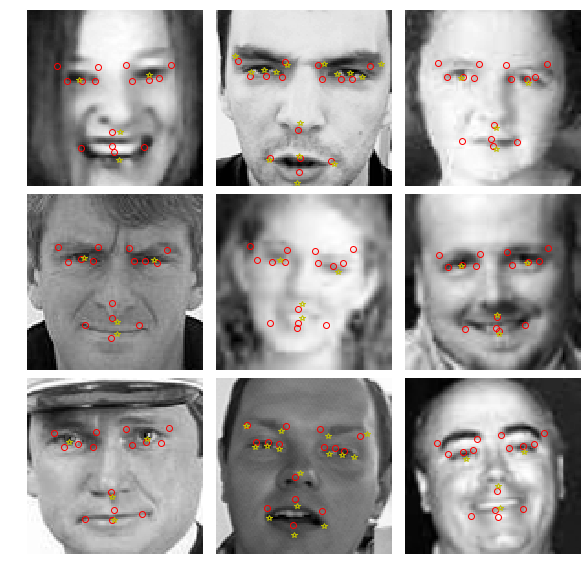

In [95]:
grid_size = 3
fig, axes = plt.subplots(grid_size, grid_size, gridspec_kw = dict(hspace = .05, wspace = .05), 
                         figsize=(10,10))

selection = np.random.choice(range(len(x_cv)), size = grid_size**2, )

mean_x_points = [keypoints_mean[j] for j in range(0,30,2)]
mean_y_points = [keypoints_mean[j+1] for j in range(0,30,2)]

for i, ax in zip(selection, axes.flat):

    ax.axis('off')
    # Plotting the faces
    ax.imshow(x_cv[i].reshape((96,96)),cmap='gist_gray')

 # Obtaining keypoints positions. x and y coordinates are even and odd indices respectively. 
    x_points = [predictions[i][j] for j in range(0,30,2)]
    y_points = [predictions[i][j+1] for j in range(0,30,2)]
      
    #plotting predicted keypoints
    ax.plot(x_points, y_points, 'ro', markerfacecolor = 'none')    
  
 # Plotting true keypoints
    
    x_true = [keypoints_cv.iloc[i][j] for j in range(0,30,2)]
    y_true = [keypoints_cv.iloc[i][j+1] for j in range(0,30,2)]
    
    ax.plot(x_true, y_true, 'y*', markerfacecolor = 'none')    
    
 # Including mean keypoints
       
    #ax.plot(mean_x_points, mean_y_points, 'b+', markerfacecolor = 'none')  